In [1]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, PNDMScheduler, DDPMScheduler
from transformers import T5EncoderModel, T5TokenizerFast
import torch
import os
import numpy as np
import librosa
from tqdm import tqdm
import soundfile as sf
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
torch_device = torch.device("cuda:0")
num_inference_steps = 100
guidance_scale= 7.5

In [3]:
model_path = "/blob/v-yuancwang/AudioEditingModel/Diffusion_SG/checkpoint-350000"
unet_path = "/blob/v-yuancwang/AUDITPLUS/AUDIT_CD_100/checkpoint-24000"

In [ ]:
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(unet_path)
tokenizer = T5TokenizerFast.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(model_path, subfolder="text_encoder")

vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)

In [21]:
text = "A girl gives a speech"
prompt = [text]
text_input = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="do_not_pad", return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * 1, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
print(text_embeddings.shape)
# print(uncond_embeddings.shape)
text_embeddings = text_embeddings
# text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

torch.Size([1, 7, 768])


In [22]:
noisy_latents = torch.randn((1, 4, 10, 78)).to(torch_device)
with torch.no_grad():
    timesteps = torch.tensor(990).to(torch_device)
    c_skip = 0.25 / (0.25 + (timesteps / 1000 - 0.0) ** 2)
    c_out = 0.5 * (timesteps / 1000 - 0.0) / ((timesteps / 1000) ** 2 + 0.25) ** 0.5
    pred_target = c_skip.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * noisy_latents + c_out.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * unet(noisy_latents, timesteps, text_embeddings).sample

In [23]:
latents_out = pred_target
with torch.no_grad():
    res = vae.decode(latents_out).sample
res = res.cpu().numpy()[0,0,:,:]

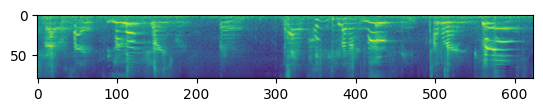

In [24]:
plt.imshow(res)

In [25]:
np.save(text, res)

In [26]:
Audio("/home/v-yuancwang/AUDIT_v2/como/test_wav/A girl gives a speech.wav")

In [7]:
scheduler = DDPMScheduler.from_pretrained(model_path, subfolder="scheduler")
print(scheduler.num_train_timesteps)

1000


In [8]:
betas = scheduler.betas.clone().detach()
num_train_timesteps = scheduler.num_train_timesteps
betas = betas * num_train_timesteps
print(len(betas), betas[0], betas[-1])
betas_cumsum = torch.cumsum(betas, dim=0)
print(len(betas_cumsum), betas_cumsum[0], betas_cumsum[-1])

1000 tensor(0.8500) tensor(12.0000)
1000 tensor(0.8500) tensor(5348.9927)


In [9]:
num_inference_steps = 1000
scheduler.set_timesteps(num_inference_steps)
print(len(scheduler.timesteps), scheduler.timesteps[0], scheduler.timesteps[-1])

1000 tensor(999) tensor(0)


In [42]:
def get_beta_cum_t(betas, timesteps, num_train_timesteps=1000):
    dt = 1 / num_train_timesteps
    betas_cumsum = torch.cumsum(betas, dim=0)
    return betas_cumsum[timesteps] * dt

def get_mean(betas, timesteps, num_train_timesteps=1000):
    return torch.exp(-0.5 * get_beta_cum_t(betas, timesteps, num_train_timesteps))

def get_variance(betas, timesteps, num_train_timesteps=1000):
    return 1.0 - torch.exp(-get_beta_cum_t(betas, timesteps, num_train_timesteps))

def get_logp_xt(pred_noise, betas, timesteps, num_train_timesteps=1000):
    variance = get_variance(betas, timesteps, num_train_timesteps).to(device=pred_noise.device, dtype=pred_noise.dtype)
    print(pred_noise.shape)
    return - pred_noise / (variance ** 0.5).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

def ode_step(xt, pred_noise, betas, total_inference_steps, inference_steps, num_train_timesteps=1000):
    dt = - 1 / total_inference_steps
    logp_xt = get_logp_xt(pred_noise, betas, inference_steps, num_train_timesteps)
    print(logp_xt.shape)
    return xt + dt * (-0.5) * (xt + logp_xt) * betas[inference_steps].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(device=pred_noise.device)

In [44]:
inference_steps = torch.randint(0, 1000, (100,))
print(inference_steps)
inference_steps = inference_steps.long()
xt = torch.randn(100, 4, 10, 78)
pred_noise = torch.randn(100, 4, 10, 78)
print(get_mean(betas, inference_steps + 1).shape)
print(get_variance(betas, inference_steps + 1).shape)
print(ode_step(xt, pred_noise, betas, 1000, inference_steps).shape)

tensor([329, 751, 936, 562, 406, 971, 949, 733, 447, 246, 299, 166, 698, 502,
        251, 295, 844,  88, 219, 175, 803,  64, 398, 315, 481,  76, 843, 469,
         32, 254, 255, 573, 567, 969, 658,  10, 766, 621, 247,   6, 446, 102,
        103, 438, 695,  80, 996, 943, 400, 136, 469, 158, 935, 945, 895, 617,
        911, 496, 719, 479, 895,  99, 828, 662, 213, 187, 891, 409, 373, 869,
        202,  58, 851, 839, 207, 491, 198, 217, 109, 244, 484, 918, 214, 864,
        448, 669, 661, 340, 204, 413, 855, 659,   7,  76, 822,  64, 220, 388,
        395, 241])
torch.Size([100])
torch.Size([100])
torch.Size([100, 4, 10, 78])
torch.Size([100, 4, 10, 78])
torch.Size([100, 4, 10, 78])


In [ ]:
timesteps = scheduler.timesteps
print(timesteps[::5])

In [ ]:
text = "baby crying"

In [ ]:
prompt = [text]
text_input = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="do_not_pad", return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * 1, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
print(text_embeddings.shape)
print(uncond_embeddings.shape)
text_embeddings = text_embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
latents = torch.randn((1, 4, 10, 78)).to(torch_device)

In [ ]:
for inference_step in tqdm(timesteps[::5]):
    with torch.no_grad():
        latent_model_input = torch.cat([latents] * 2)
        pred_noise = unet(latent_model_input, inference_step, encoder_hidden_states=text_embeddings).sample
        noise_pred_uncond, noise_pred_text = pred_noise.chunk(2)
        pred_noise = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        latents = ode_step(latents, pred_noise, betas, 200, inference_step)

In [ ]:
latents_out = latents
with torch.no_grad():
    res = vae.decode(latents_out).sample
res = res.cpu().numpy()[0,0,:,:]

In [ ]:
plt.imshow(res)

In [ ]:
np.save(os.path.join("/home/v-yuancwang/AUDIT_v2/test_mel", text+".npy"), res)

In [ ]:
# Audio("/home/v-yuancwang/AUDIT_v2/test_wav/play guitar.wav")